### Overall sales of JGI from 2074-81
1. lags taken 1,2 and 12 from ACF and PACF graph
2. Random Forest and XG boost



In [54]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [55]:
# Load dataset
data = pd.read_csv(r"dataset\data_without_query_from_2074-2081_in million.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


In [56]:

# data visualization using plotly

import plotly.graph_objs as go
import plotly.offline as pyo

df_sales = pd.read_csv(r"dataset\company_01_merge_sales.csv")

df_sales.columns = ['date','sales']

df_sales[['Year', 'Month']] = df_sales['date'].str.split('-', expand=True)
df_sales['Year'] = df_sales['Year'].astype(int)
df_sales['Month'] = df_sales['Month'].astype(int)
nepali_months_fiscal_order = {
    4: "Shrawan", 5: "Bhadra", 6: "Asoj", 7: "Kartik",
    8: "Mangsir", 9: "Poush", 10: "Magh", 11: "Falgun",
    12: "Chaitra", 1: "Baishakh", 2: "Jestha", 3: "Ashadh"
}

df_sales['Month_Name'] = df_sales['Month'].map(nepali_months_fiscal_order)


df_sales['Fiscal_Year'] = df_sales.apply(lambda row: 
                                         f"{row['Year']}-{row['Year']+1}" if row['Month'] >= 4 
                                         else f"{row['Year']-1}-{row['Year']}", axis=1)

df_sales['Month_Order'] = df_sales['Month'].apply(lambda x: list(nepali_months_fiscal_order.keys()).index(x))

df_sales = df_sales.sort_values(by=['Fiscal_Year', 'Month_Order'])

fig = go.Figure()

fiscal_years = df_sales['Fiscal_Year'].unique()

for fy in fiscal_years:
    df_fy = df_sales[df_sales['Fiscal_Year'] == fy]
    fig.add_trace(go.Scatter(
        x=df_fy['Month_Name'], 
        y=df_fy['sales'], 
        mode='lines+markers',
        name=f'Fiscal Year {fy}',
        line=dict(shape='spline')  
    ))

fig.update_layout(
    title="Sales Trend by Fiscal Year",
    xaxis_title="Nepali Month",
    yaxis_title="Sales",
    xaxis=dict(categoryorder='array', categoryarray=list(nepali_months_fiscal_order.values())),
    template="plotly_dark",
    hovermode="x unified"
)

pyo.iplot(fig)


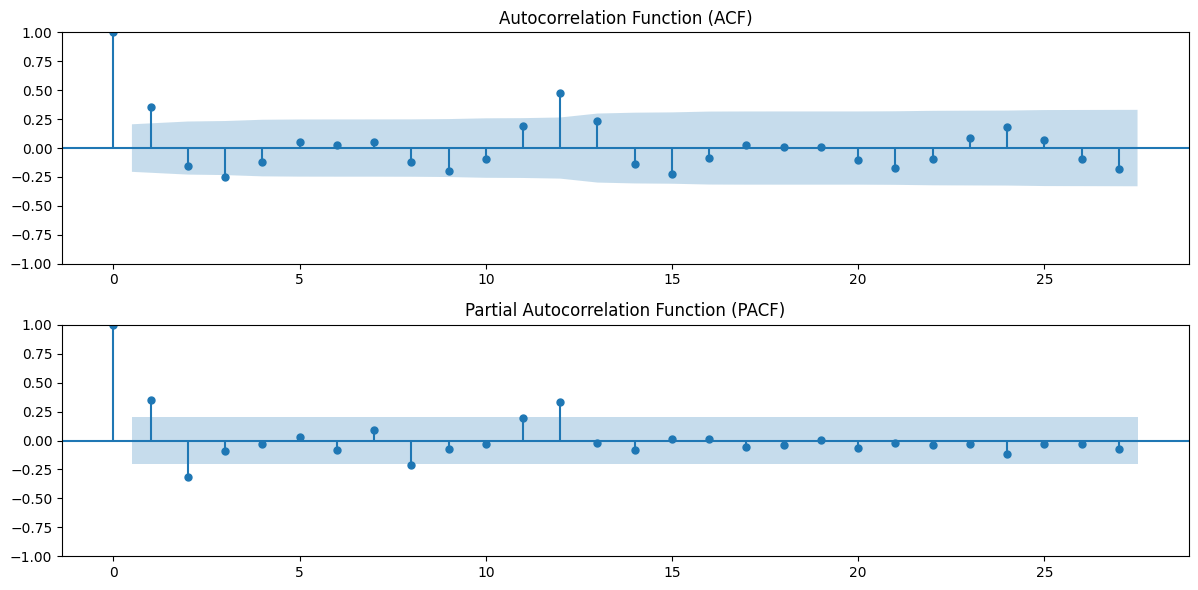

In [57]:
# analyzing auto_correlation and partial auto correlation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Calculate the ACF and PACF

acf_values = acf(data["sales"], nlags=27, fft=False)
pacf_values = pacf(data["sales"], nlags=27)

# Plot the ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(data["sales"], lags=27, ax=plt.gca())  
plt.title("Autocorrelation Function (ACF)")

plt.subplot(2, 1, 2)
plot_pacf(data["sales"], lags=27, ax=plt.gca())  
plt.title("Partial Autocorrelation Function (PACF)")


plt.tight_layout()
plt.show()




In [58]:
print(f"The ACF values are : \n{acf_values}")


The ACF values are : 
[ 1.          0.35122888 -0.15196804 -0.24916899 -0.11783802  0.04855957
  0.02801156  0.05283397 -0.11993052 -0.19997901 -0.09409724  0.18636741
  0.47693338  0.23113452 -0.137082   -0.22760606 -0.08357401  0.02859312
  0.00810387  0.01321749 -0.10616415 -0.17283492 -0.09530256  0.08905882
  0.18355165  0.07346874 -0.09452208 -0.18526717]


In [59]:

print(f"The PACF values are : \n{pacf_values}")
a= pacf_values

The PACF values are : 
[ 1.          0.35513142 -0.32212756 -0.08977107 -0.02748093  0.03729998
 -0.08381962  0.09573322 -0.23584681 -0.08430266 -0.03433029  0.23023554
  0.39586459 -0.01423715 -0.11177289 -0.00132953  0.01596467 -0.06243855
 -0.05062088  0.00541394 -0.09830755 -0.04523504 -0.06004202 -0.03226769
 -0.15679877 -0.0501237  -0.03895767 -0.11131342]


In [60]:
# converting acf values into list so that indexing can be done
acf=[]
for i in range (len(acf_values)):
    acf.append(acf_values[i])

In [61]:
#converting pacf values into list so that indexing can be done
pacf=[]
for i in range(len(pacf_values)):
    pacf.append(pacf_values[i])

In [62]:
type(pacf)

list

In [63]:
acf

[1.0,
 0.3512288769573043,
 -0.15196803827523458,
 -0.24916898767989176,
 -0.11783801531056981,
 0.04855956540293954,
 0.02801155562727049,
 0.05283397364171068,
 -0.11993052393512146,
 -0.19997901428938258,
 -0.09409724453909948,
 0.18636740706900423,
 0.4769333796066044,
 0.23113452275068086,
 -0.13708199563582368,
 -0.22760605820860955,
 -0.08357400826399643,
 0.02859312099495851,
 0.008103873200129202,
 0.013217486755032844,
 -0.10616414602859954,
 -0.17283491886012686,
 -0.09530256441675296,
 0.08905881518426245,
 0.18355164981048733,
 0.07346874184280724,
 -0.09452208459412294,
 -0.18526717304353207]

In [64]:
acf.index(1)

0

In [65]:
# selected_features=[]
# for i in range (len(acf)):
#     if abs(acf[i])>0.3 or abs(pacf[i]>0.3):
#         index=acf.index(acf[i]) or pacf.index(pacf[i])
#         lag=f"lag_{index}"
#         selected_features.append(lag)
        

In [86]:
imp_features=[]
for i in range (len(acf)):
    if abs(acf[i]>0.3):
        index = acf.index(acf[i])
        lag = f"lag_{index}"
        imp_features.append(lag)


In [66]:
# selected_features

In [67]:
# a=[1,2,3,4,5,6,77,8]
# # a.index(77)
# type(a)


In [68]:
# selected_features=[]
# for i in range(len(acf_values)-1):
#     if acf_values[i]>0.3:
        


In [ ]:
# Feature Engineering
data['month'] = data.index.month
data['year'] = data.index.year
data['dayofweek'] = data.index.dayofweek
data['lag_1']=data['sales'].shift(1)
data['lag_2']=data['sales'].shift(2)

data['lag_12'] = data['sales'].shift(12)



data['rolling_mean_3'] = data['sales'].rolling(window=3).mean()
data['rolling_mean_6'] = data['sales'].rolling(window=6).mean()

data.dropna(inplace=True)

In [70]:
# Train-Test Split 80% and 20%
X = data.drop(columns=['sales'])
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=False)

In [71]:
print(f"The length of training data is : {len(X_train)} and the length of testing data is : {len(X_test)}")

The length of training data is : 31 and the length of testing data is : 48


In [72]:
# Standardization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [73]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42, n_jobs=-1, verbose=1)
rf_model.fit(X_train_scaled, y_train_scaled)
yran_pred_scaled = rf_model.predict(X_test_scaled)
yran_pred = scaler_y.inverse_transform(yran_pred_scaled.reshape(-1, 1)).flatten()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [74]:
y_pred_scaled = rf_model.predict(X_test_scaled)
yran_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [75]:
# Random Forest Metrics
mae_rf = mean_absolute_error(y_test, yran_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, yran_pred))
rsquare = r2_score(y_test,yran_pred)
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R^2: {rsquare:.3f}")


Random Forest MAE: 506634.87
Random Forest RMSE: 737148.36
Random Forest R^2: 0.462


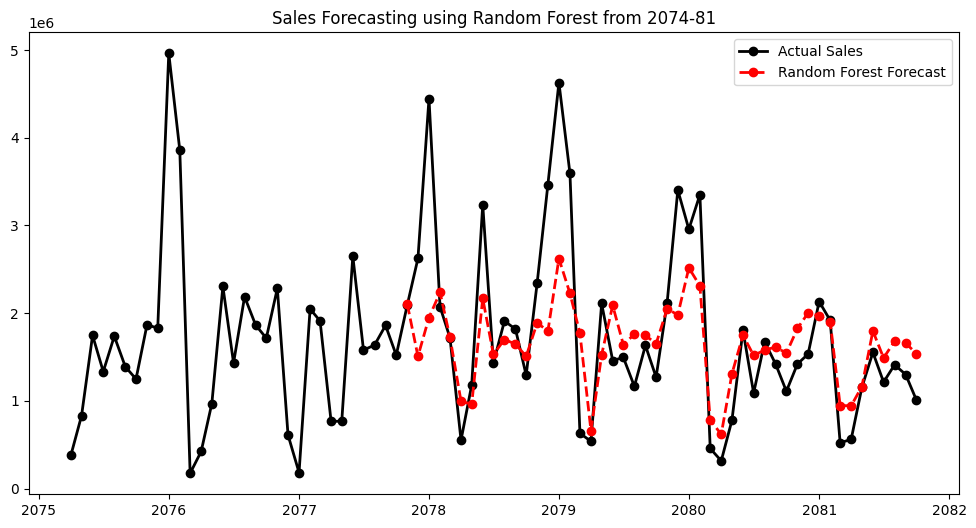

In [91]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["sales"], label="Actual Sales", color="black", linewidth=2, marker='o')
plt.plot(X_test.index, yran_pred, label="Random Forest Forecast", color="red", linestyle="dashed", linewidth=2, marker='o')

plt.title("Sales Forecasting using Random Forest from 2074-81")
plt.legend()
plt.show()



### Observation
1. for long series data i.e. from 2074 to 2081 it couldnot map properly becase of year 2076-2077 may due to ##Covid 19.
2. That year effected whole dataset because model couldnot gain more height after that.
3. so it maynot be accurate to take outlier year. Instead consider it as an outlier

### XG boost model

In [77]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="rmse")
xgb_model.fit(X_train_scaled, y_train_scaled, eval_set=[(X_test_scaled, y_test_scaled)], verbose=True)
yxg_pred_scaled = xgb_model.predict(X_test_scaled)
yxg_pred = scaler_y.inverse_transform(yxg_pred_scaled.reshape(-1, 1)).flatten()


[0]	validation_0-rmse:1.02917
[1]	validation_0-rmse:1.02707
[2]	validation_0-rmse:1.02476
[3]	validation_0-rmse:1.02242
[4]	validation_0-rmse:1.02128
[5]	validation_0-rmse:1.01829
[6]	validation_0-rmse:1.01569
[7]	validation_0-rmse:1.01325
[8]	validation_0-rmse:1.01361
[9]	validation_0-rmse:1.01033
[10]	validation_0-rmse:1.00531
[11]	validation_0-rmse:1.00085
[12]	validation_0-rmse:0.99934
[13]	validation_0-rmse:0.99655
[14]	validation_0-rmse:0.99424
[15]	validation_0-rmse:0.99293
[16]	validation_0-rmse:0.98759
[17]	validation_0-rmse:0.98517
[18]	validation_0-rmse:0.98407
[19]	validation_0-rmse:0.98363
[20]	validation_0-rmse:0.97960
[21]	validation_0-rmse:0.97967
[22]	validation_0-rmse:0.98041
[23]	validation_0-rmse:0.97844
[24]	validation_0-rmse:0.97879
[25]	validation_0-rmse:0.97803
[26]	validation_0-rmse:0.97431
[27]	validation_0-rmse:0.97477
[28]	validation_0-rmse:0.97199
[29]	validation_0-rmse:0.97194
[30]	validation_0-rmse:0.96821
[31]	validation_0-rmse:0.96544
[32]	validation_0-

In [78]:
# XGBoost Metrics
mae_xgb = mean_absolute_error(y_test, yxg_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, yxg_pred))
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost MAE: 589441.25
XGBoost RMSE: 896825.61


In [79]:
from sklearn.metrics import r2_score

r2_rf = r2_score(y_test, yxg_pred)
print(f"XG boost R² Score: {r2_rf:.4f}")

XG boost R² Score: 0.2038


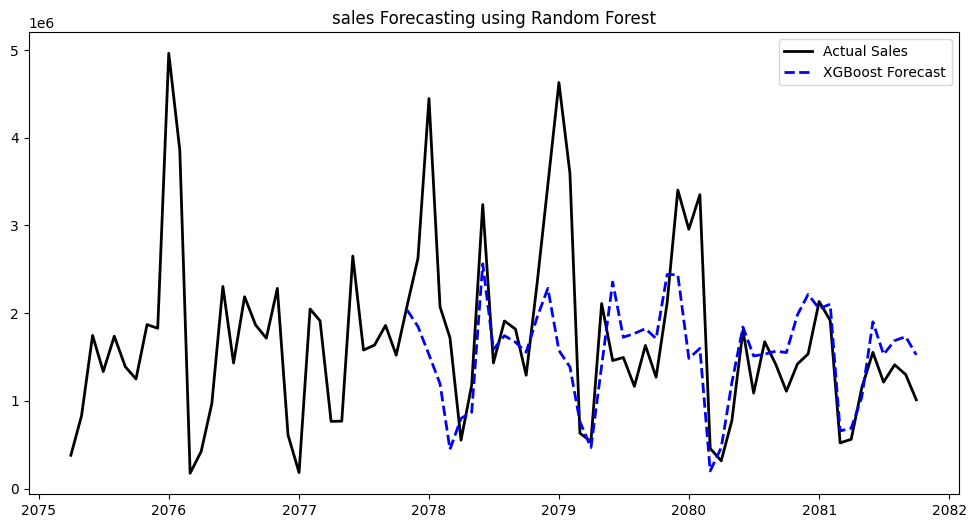

In [80]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["sales"], label="Actual Sales", color="black", linewidth=2)
# plt.plot(X_test.index, yran_pred, label="Random Forest Forecast", color="red", linestyle="dashed", linewidth=2)

plt.plot(X_test.index, yxg_pred, label="XGBoost Forecast", color="blue", linestyle="dashed", linewidth=2)
plt.title("sales Forecasting using Random Forest")
plt.legend()
plt.show()



In [81]:
# data["sales"][-16:]
data.index[-(len(X_test)):]

DatetimeIndex(['2077-11-01', '2077-12-01', '2078-01-01', '2078-02-01',
               '2078-03-01', '2078-04-01', '2078-05-01', '2078-06-01',
               '2078-07-01', '2078-08-01', '2078-09-01', '2078-10-01',
               '2078-11-01', '2078-12-01', '2079-01-01', '2079-02-01',
               '2079-03-01', '2079-04-01', '2079-05-01', '2079-06-01',
               '2079-07-01', '2079-08-01', '2079-09-01', '2079-10-01',
               '2079-11-01', '2079-12-01', '2080-01-01', '2080-02-01',
               '2080-03-01', '2080-04-01', '2080-05-01', '2080-06-01',
               '2080-07-01', '2080-08-01', '2080-09-01', '2080-10-01',
               '2080-11-01', '2080-12-01', '2081-01-01', '2081-02-01',
               '2081-03-01', '2081-04-01', '2081-05-01', '2081-06-01',
               '2081-07-01', '2081-08-01', '2081-09-01', '2081-10-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [82]:
data.index[:-(len(X_test))]

DatetimeIndex(['2075-04-01', '2075-05-01', '2075-06-01', '2075-07-01',
               '2075-08-01', '2075-09-01', '2075-10-01', '2075-11-01',
               '2075-12-01', '2076-01-01', '2076-02-01', '2076-03-01',
               '2076-04-01', '2076-05-01', '2076-06-01', '2076-07-01',
               '2076-08-01', '2076-09-01', '2076-10-01', '2076-11-01',
               '2076-12-01', '2077-01-01', '2077-02-01', '2077-03-01',
               '2077-04-01', '2077-05-01', '2077-06-01', '2077-07-01',
               '2077-08-01', '2077-09-01', '2077-10-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [83]:
data["sales"][:-(len(X_test))]

date
2075-04-01     378902.612
2075-05-01     829865.695
2075-06-01    1746060.327
2075-07-01    1333439.695
2075-08-01    1736802.965
2075-09-01    1388630.073
2075-10-01    1248765.667
2075-11-01    1869286.573
2075-12-01    1827143.181
2076-01-01    4963822.732
2076-02-01    3857721.124
2076-03-01     173641.299
2076-04-01     422148.401
2076-05-01     969291.923
2076-06-01    2304377.182
2076-07-01    1431445.462
2076-08-01    2187042.394
2076-09-01    1864700.025
2076-10-01    1714617.569
2076-11-01    2282201.108
2076-12-01     610578.237
2077-01-01     181453.364
2077-02-01    2047487.313
2077-03-01    1911844.418
2077-04-01     765539.316
2077-05-01     768077.232
2077-06-01    2651188.887
2077-07-01    1579149.317
2077-08-01    1635635.748
2077-09-01    1860109.562
2077-10-01    1520314.982
Name: sales, dtype: float64

### Visualization of Random Forest and XG boost model

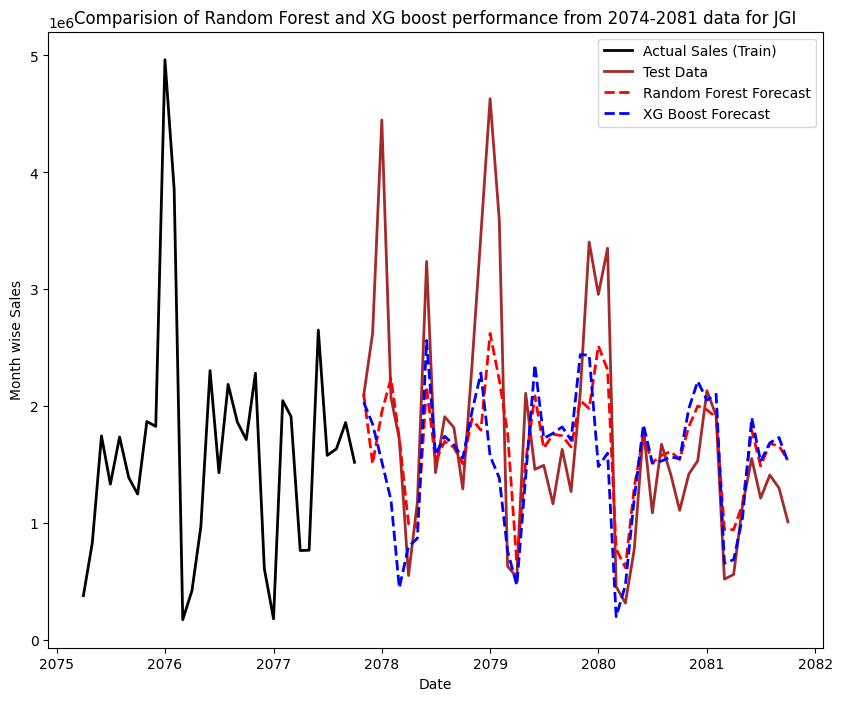

In [84]:
plt.figure(figsize=(10,8))
plt.plot(data.index[:-(len(X_test))], data["sales"][:-(len(X_test))], label="Actual Sales (Train)", color="black", linestyle="solid", linewidth=2)
plt.plot(data.index[-(len(X_test)):], data["sales"][-(len(X_test)):], label="Test Data", color="brown", linestyle="solid", linewidth=2)
plt.plot(X_test.index, yran_pred, label="Random Forest Forecast", color="red", linestyle="dashed", linewidth=2 )
plt.plot(X_test.index, yxg_pred, label="XG Boost Forecast", color="blue", linestyle="dashed", linewidth=2)
plt.title("Comparision of Random Forest and XG boost performance from 2074-2081 data for JGI")
plt.xlabel("Date")
plt.ylabel("Month wise Sales")
plt.legend()
plt.show()

In [85]:
X_test.index

DatetimeIndex(['2077-11-01', '2077-12-01', '2078-01-01', '2078-02-01',
               '2078-03-01', '2078-04-01', '2078-05-01', '2078-06-01',
               '2078-07-01', '2078-08-01', '2078-09-01', '2078-10-01',
               '2078-11-01', '2078-12-01', '2079-01-01', '2079-02-01',
               '2079-03-01', '2079-04-01', '2079-05-01', '2079-06-01',
               '2079-07-01', '2079-08-01', '2079-09-01', '2079-10-01',
               '2079-11-01', '2079-12-01', '2080-01-01', '2080-02-01',
               '2080-03-01', '2080-04-01', '2080-05-01', '2080-06-01',
               '2080-07-01', '2080-08-01', '2080-09-01', '2080-10-01',
               '2080-11-01', '2080-12-01', '2081-01-01', '2081-02-01',
               '2081-03-01', '2081-04-01', '2081-05-01', '2081-06-01',
               '2081-07-01', '2081-08-01', '2081-09-01', '2081-10-01'],
              dtype='datetime64[ns]', name='date', freq=None)